https://github.com/int-brain-lab/iblvideo/blob/c25e7572153c87a90683021490e010ce55140a88/prototyping/post_dlc/pupil_diameter.py

In [1]:
import os
import numpy as np
from one.api import ONE
import pickle
import pandas as pdS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_raw_and_smooth_position, get_pupil_diameter, stack_pupil, get_dlc_XYs
from one_functions_generic import subjects_interest_data, prepro, timeseries_PSTH

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/tmpmfftsq8y/cache.zip Bytes: 107366850


100%|██████████| 102.39300727844238/102.39300727844238 [00:16<00:00,  6.26it/s]


### Get sessions from mice of interest

In [2]:
data_path =  '/home/ines/repositories/representation_learning_variability/Video/'
#data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'
os.chdir(data_path)

mice = pickle.load(open("subject_intersection", "rb"))
naive_sessions = pickle.load(open("good_naive_sessions", "rb"))


### Parameters

In [3]:
event = 'stimOn_times'
#event = 'feedback_times'
t_init = 0.5
t_end = 2

### Loop through mice and plot for naif and proficient sessions

In [3]:
# Find paired sessions for each mouse
one = ONE()
for s, naif_session in enumerate(naive_sessions):
    naive_sessions = ['f359281f-6941-4bfd-90d4-940be22ed3c3']
    # Get mouse name
    session_details = one.list_datasets(naif_session, details=True)
    parts = session_details['session_path'][0].split('/')
    mouse_name = '/'.join(parts[2:3])
    
    if mouse_name in mice:
        
        # Get pupil diameter for each of the sessions
        pupil_dia_raw_naif, pupil_dia_smooth_naif = (
            get_raw_and_smooth_pupil_dia(naif_session, video_type='left', ephys=False, get_pupil_diameter))
        times_naif, XYs_naif = get_dlc_XYs_pupil(one, naif_session, view='left', likelihood_thresh=0.9)
        
        # Check if dataset is consistent for naive sessions
        if np.abs((len(times_naif) - len(XYs_naif['pupil_bottom_r']))) < 5: 
                
            # Get corresponding proficient sessions
            prof_sessions = subjects_interest_data([mouse_name], 'proficient', 'ephys')
            
            if len(prof_sessions) > 0:
                prof_sessions = prof_sessions['session'].unique()
                prof_session = prof_sessions[-1]

                # Continue download
                pupil_dia_raw_prof, pupil_dia_smooth_prof = (
                    get_raw_and_smooth_pupil_dia(prof_session, video_type='left', ephys=True))
                times_prof, XYs_prof = get_dlc_XYs_pupil(one, prof_session, view='left', likelihood_thresh=0.9)
                
                # Check if dataset is consistent for proficient sessions
                if np.abs((len(times_prof) - len(XYs_prof['pupil_bottom_r']))) < 5: 
                    # Get trials for corresponding sessions
                    trials_naive = one.load_object(naif_session, obj='trials', namespace='ibl')
                    naive_df = prepro(trials_naive.to_df())
                    
                    trials_prof = one.load_object(prof_session, obj='trials', namespace='ibl')
                    prof_df = prepro(trials_prof.to_df())
                    
                    # Stack trials 
                    stacked_naif, naif_time = stack_pupil(pupil_dia_smooth_naif, times_naif[0:len(pupil_dia_smooth_naif)], naive_df, event, t_init, t_end)
                    stacked_prof, prof_time = stack_pupil(pupil_dia_smooth_prof, times_prof[0:len(pupil_dia_smooth_prof)], prof_df, event, t_init, t_end)
                    
                    stacked_naif = pd.DataFrame(stacked_naif)
                    #stacked_naif['time'] = list(np.nanmean(stacked_naif, axis=0))
                    stacked_naif['feedback'] = list(naive_df['correct'])
                    stacked_naif['choice'] = list(naive_df['choice'])
                    stacked_naif['contrast'] = list(naive_df['contrast'])
                    stacked_naif['side'] = list(np.sign(naive_df['signed_contrast']))
                    
                    stacked_prof = pd.DataFrame(stacked_prof)
                    #stacked_prof['time'] = list(np.nanmean(stacked_prof, axis=0))
                    stacked_prof['feedback'] = list(prof_df['correct'])
                    stacked_prof['choice'] = list(prof_df['choice'])
                    stacked_prof['contrast'] = list(prof_df['contrast'])
                    stacked_prof['side'] = list(np.sign(prof_df['signed_contrast']))

                    
                    # TODO: need to fix time
                    melted_naif = pd.melt(stacked_naif, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(stacked_naif.keys()[1:-4]))
                    melted_prof = pd.melt(stacked_prof, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(stacked_prof.keys()[1:-4]))
                    mean_naif_time = np.nanmean(naif_time, axis=0)
                    mean_prof_time = np.nanmean(prof_time, axis=0)

                    # Check that there is non-nan data
                    if (np.nansum(melted_naif['value']) != 0) & (np.nansum(melted_prof['value']) != 0):
                    
                        # Plot data
                        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[12, 7])
                        sns.lineplot(x='variable', y='value', hue='feedback', data=melted_naif, ax=ax[0])
                        sns.lineplot(x='variable', y='value', hue='feedback', data=melted_prof, ax=ax[1])

                        ax[0].set_xlabel('Time (ms)')
                        ax[1].set_xlabel('Time (ms)')
                        ax[0].set_ylabel('Normalized pupil diameter')
                        #ax[0].set_xticks(mean_naif_time[np.where(mean_naif_time>0)[0][0]], [0])
                        #ax[0].set_xticks(np.nanmean(naif_time, axis=0))
                        #ax[1].set_xticks(mean_prof_time[np.where(mean_prof_time>0)[0][0]], [0])
                        ax[0].set_title('Naif session')
                        ax[1].set_title('Proficient session')
                        plt.tight_layout()

                        #print(naif_session, prof_session)
            else:
                print('Data with different lengths for session ' + str(naif_session))


NameError: name 'naive_sessions' is not defined

### Plot session plots in loop

In [2]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [7]:
event = 'stimOn_times'
t_init = 0.5
t_end = 2
save_path = '/home/ines/repositories/representation_learning_variability/Exported figures/'  # This is a temp file, need to move plots to correct dir

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


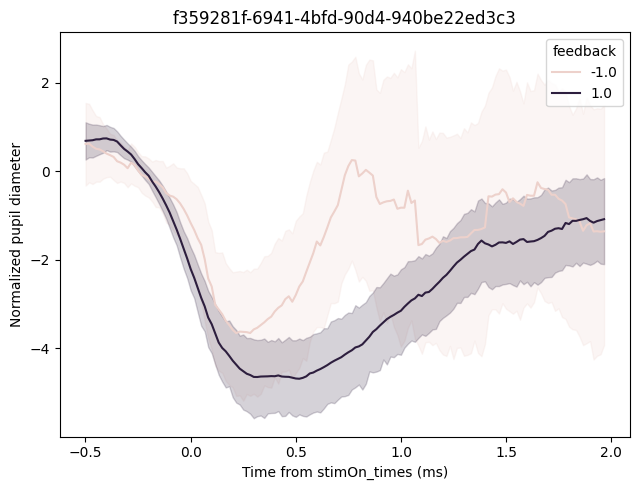

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


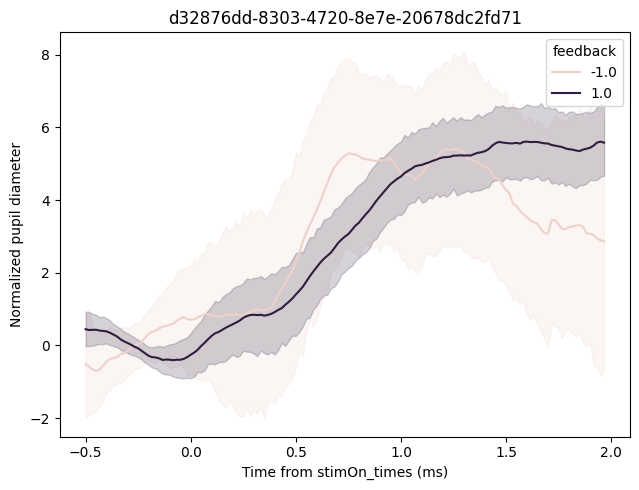

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


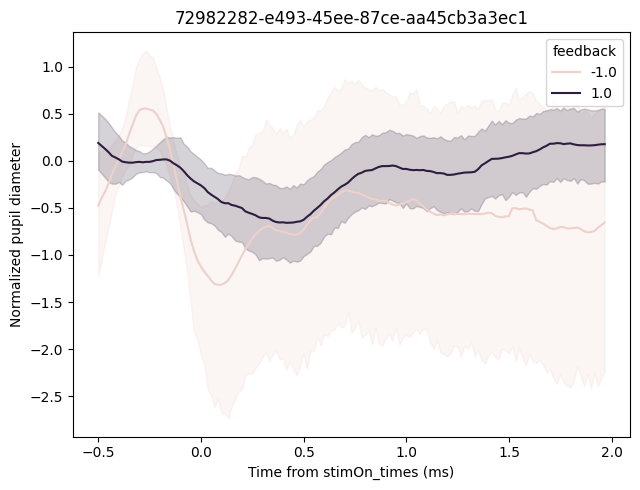

local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:17<00:00, 2.19MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:14<00:00, 2.64MB/s]


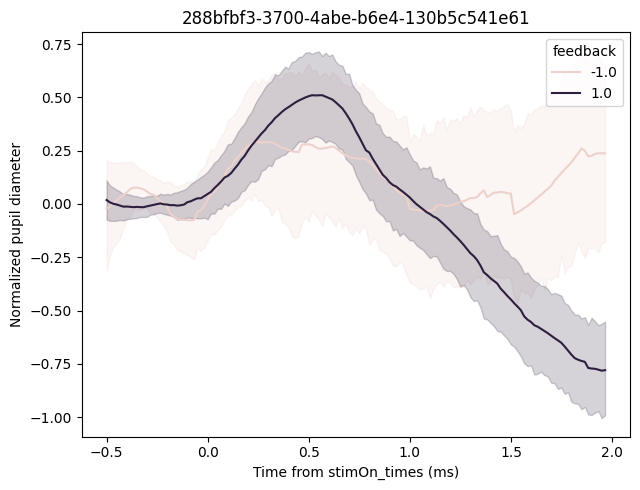

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


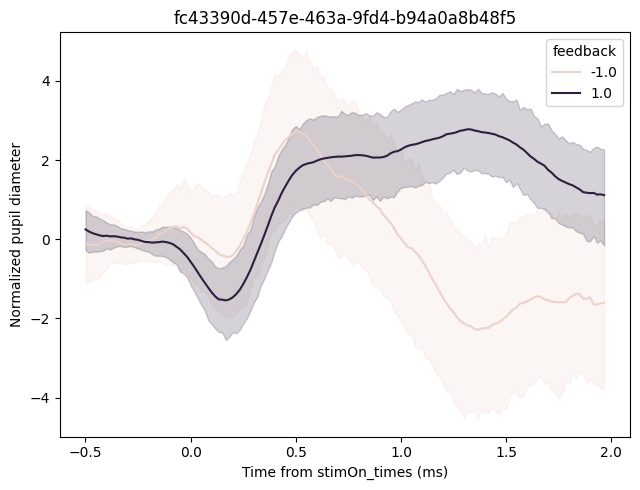

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


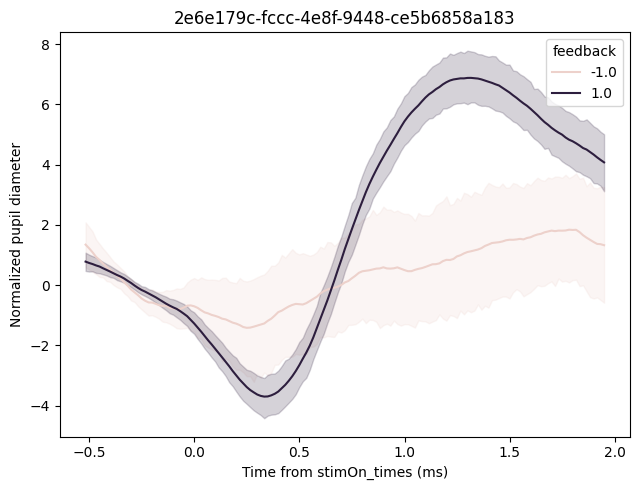

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


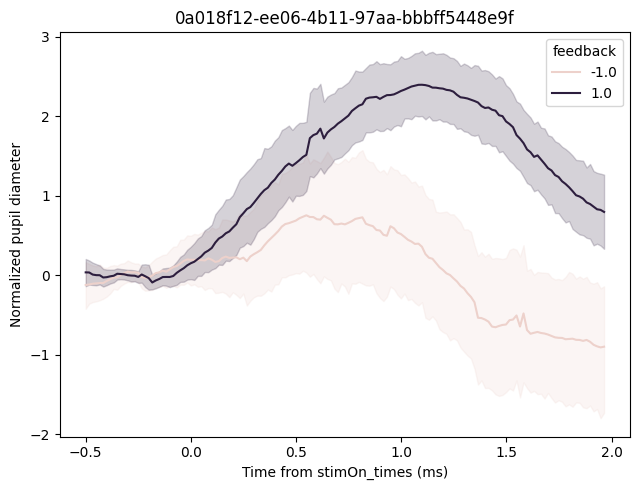

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


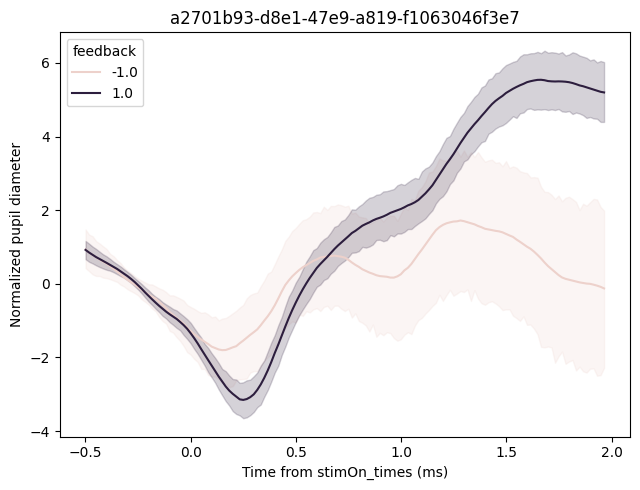

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


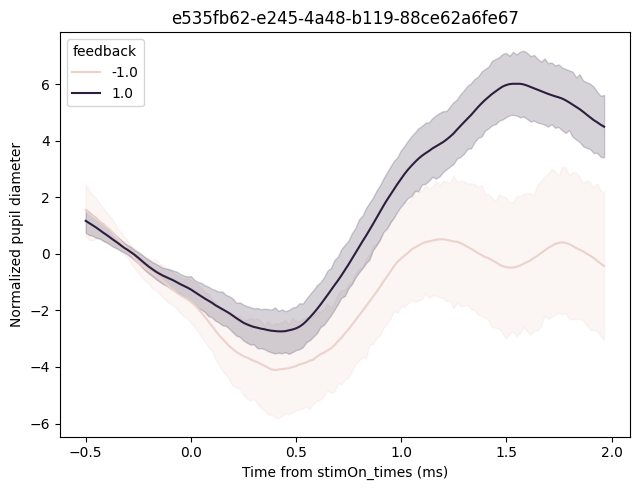

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


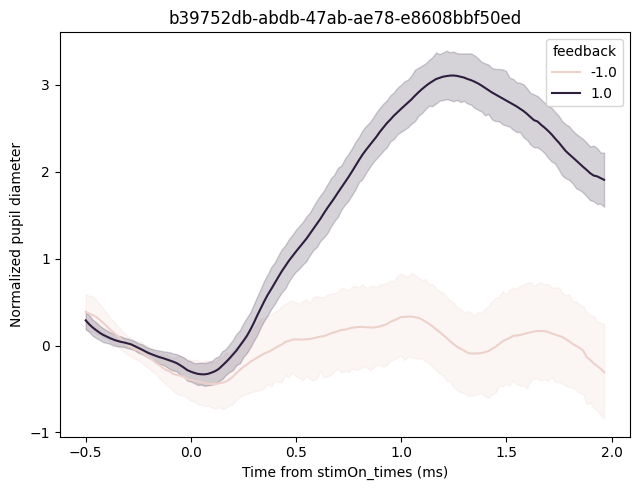

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


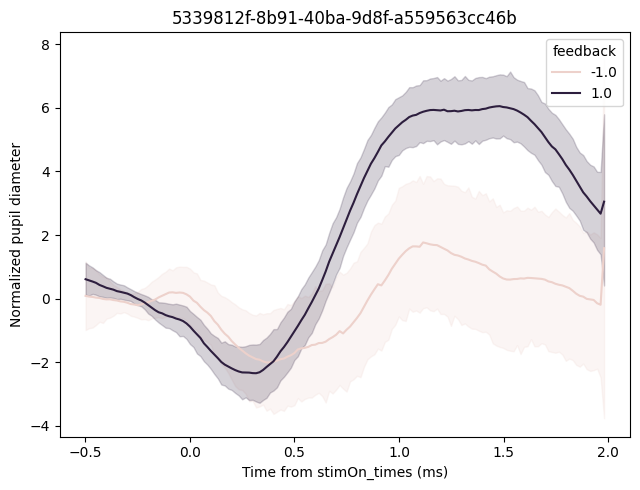

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


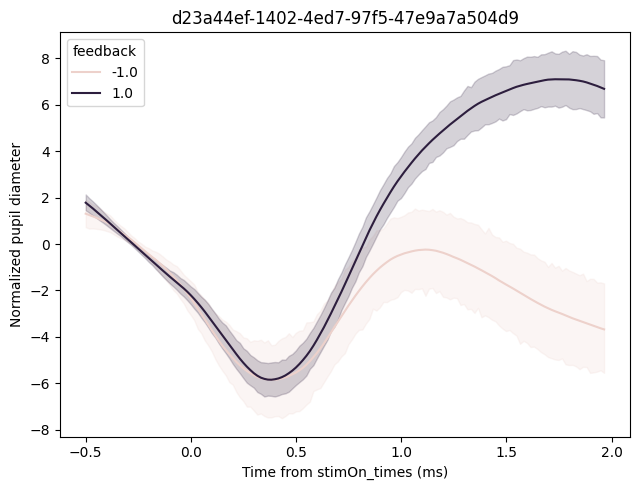

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


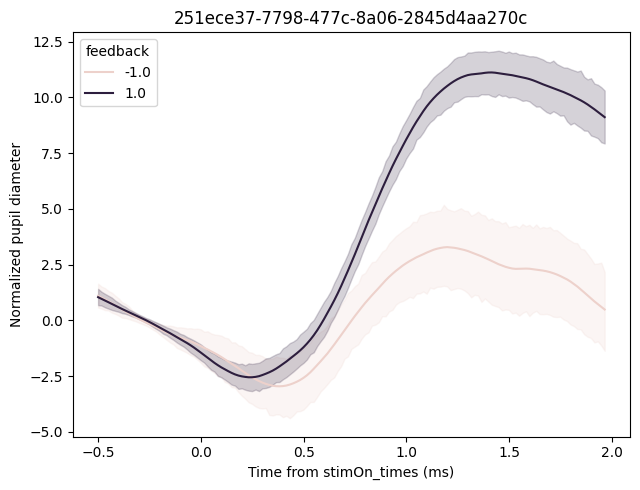

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


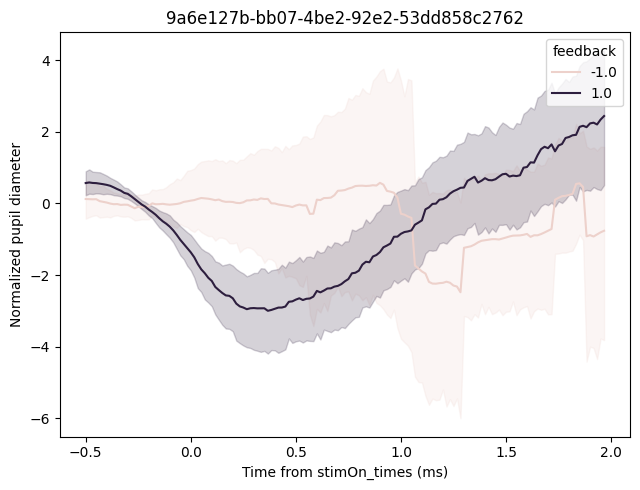

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


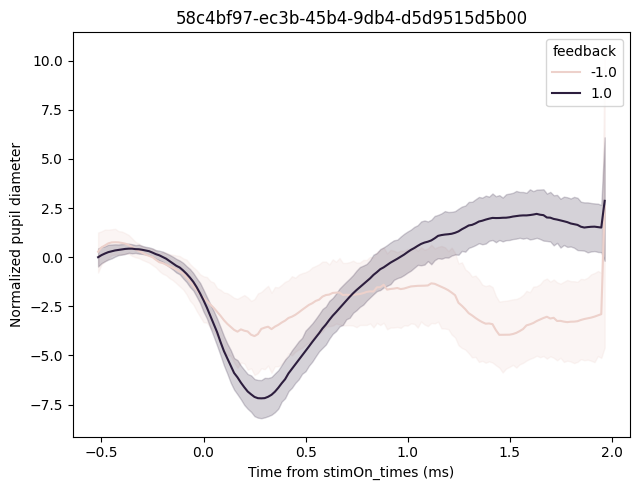

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


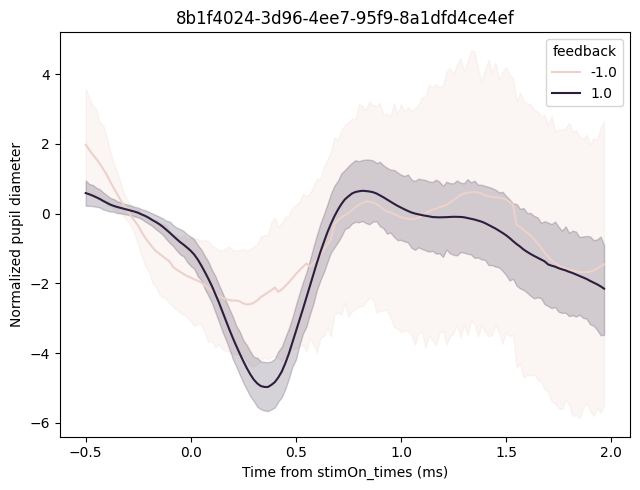

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


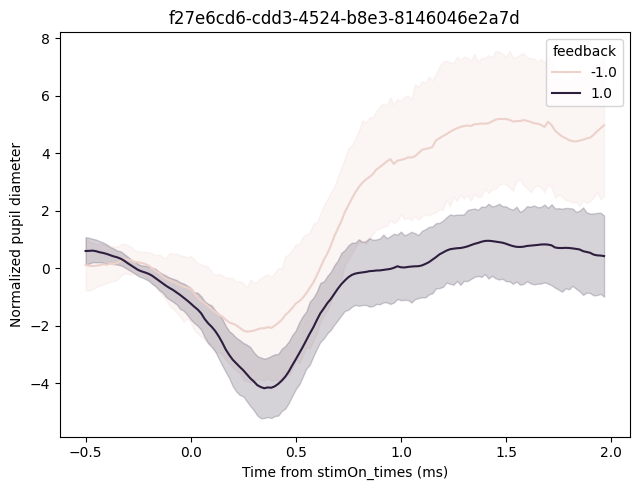

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


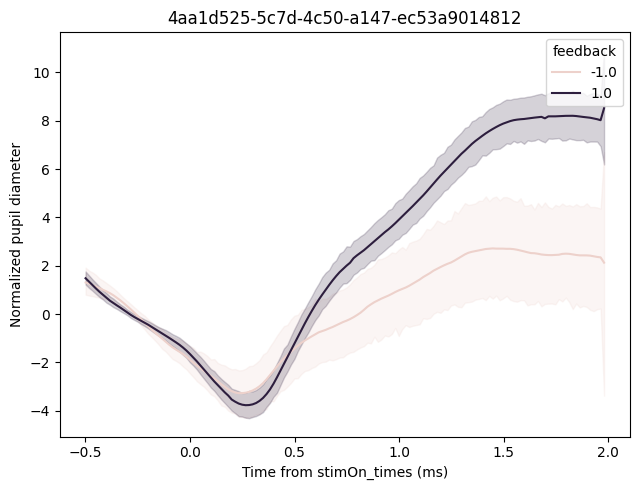

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


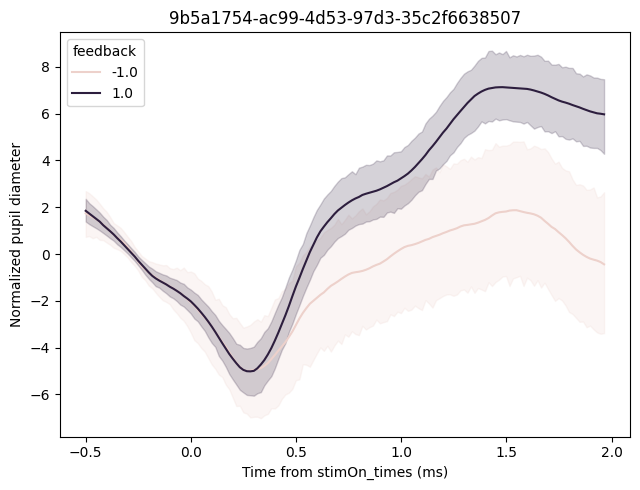

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


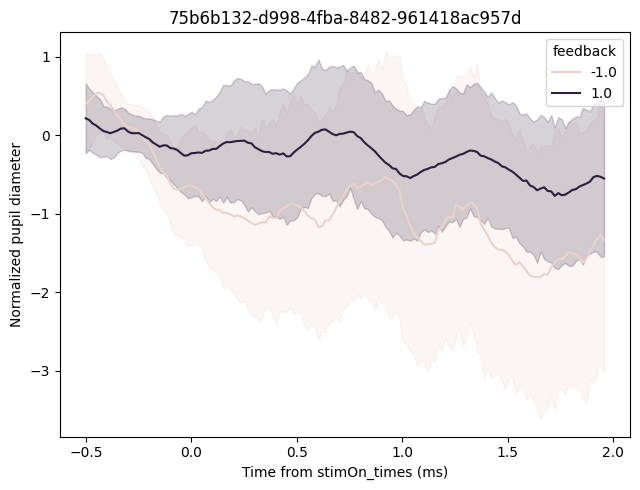

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


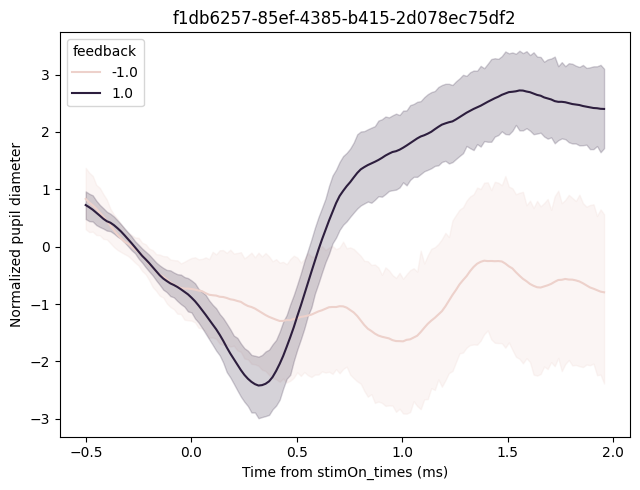

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


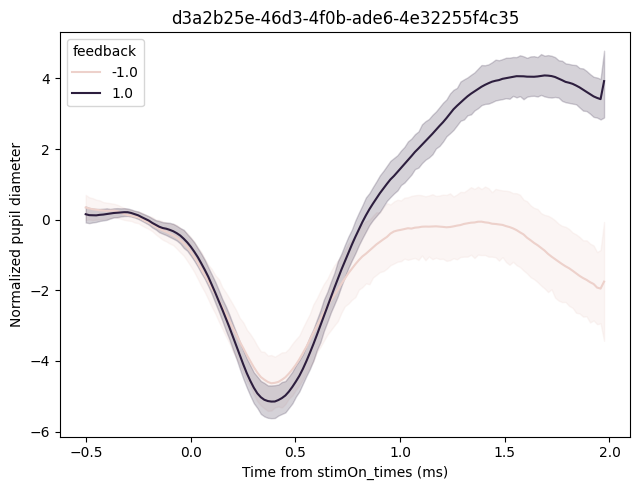

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


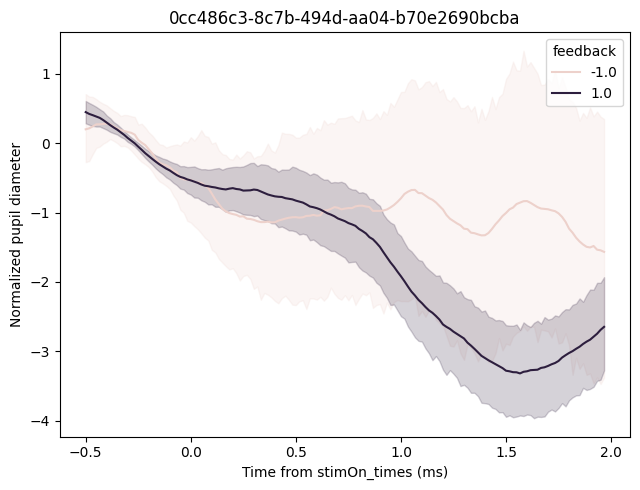

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


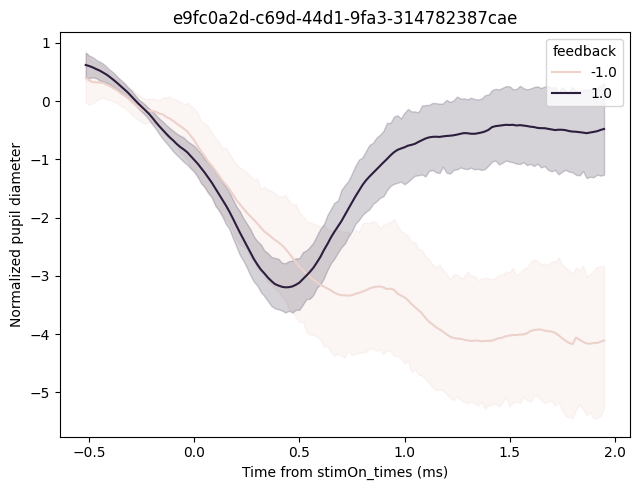

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


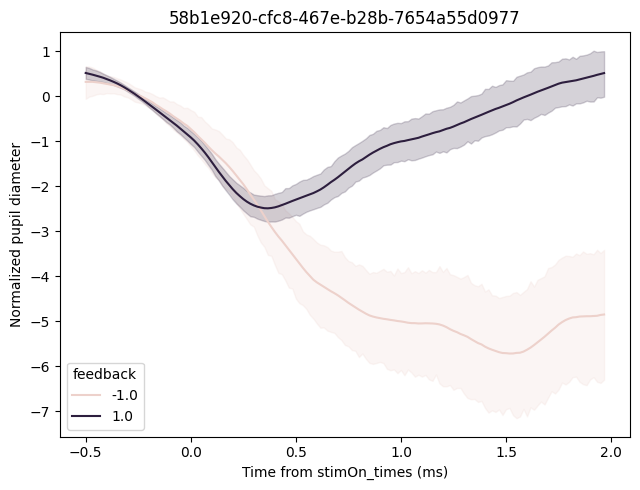

In [8]:
# Find paired sessions for each mouse
one = ONE()

for s, session in enumerate(list(pass_qc)):
    #session = 'f359281f-6941-4bfd-90d4-940be22ed3c3'

    # Get pupil diameter for each of the sessions
    pupil_dia_raw, pupil_dia_smooth, _, _ = get_raw_and_smooth_position(session, video_type='left', 
                                                                        ephys=False, position_function=get_pupil_diameter)
    times, XYs = get_dlc_XYs(session, view='left', likelihood_thresh=0.9)

    trials = one.load_object(session, obj='trials', namespace='ibl').to_df()

    stacked = timeseries_PSTH(times, pupil_dia_smooth, trials, event, t_init, t_end, subtract_baseline='pupil')

    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=[6.5, 5])
    sns.lineplot(x='variable', y='value', hue='feedback', data=stacked)
    plt.xlabel('Time from ' + str(event) + ' (ms)')
    plt.ylabel('Normalized pupil diameter')
    plt.title(session)
    plt.tight_layout()
    
    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()